# Análisis
Este programa es para ejecutar una rutina que normalice los datos simulados al valor medido experimentalmente respecto al máximo del valor Compton.

Se hace con todos los resultados obtenidos con propositos de comparación y requiere que estén los archivos de datos.

### Importar datos

El siguiente fragmento de código está cargando datos de simulación de varios archivos de texto y almacenándolos en un diccionario para su posterior análisis.

- Se definen tres listas: `archivos`, `nombres` y `titulos`. `archivos` contiene los nombres de los archivos de texto (sin la extensión `.txt`) que contienen los datos de simulación. `nombres` y `titulos` que contienen metadatos adicionales sobre las simulaciones.

- Se inicializa un diccionario vacío `simulacion`. Este diccionario se llenará con los datos de simulación.

- Luego, el código entra en un bucle que recorre cada nombre de archivo en `archivos`. Para cada nombre de archivo, se construye la ruta del archivo añadiendo la extensión `.txt`, se carga el archivo de texto en un DataFrame de pandas con `pd.read_csv`, y se añade el DataFrame al diccionario `simulacion` con el nombre del archivo como clave.

- `pd.read_csv` se llama con varios argumentos: `delimiter=' '` especifica que los datos en el archivo de texto están separados por espacios, `header=0` especifica que la primera línea del archivo de texto contiene los nombres de las columnas, y `names=['canales', 'energias', 'cuentas']` especifica los nombres de las columnas del DataFrame.

- Al final del bucle, `simulacion` es un diccionario donde cada clave es un nombre de archivo y cada valor es un DataFrame que contiene los datos de simulación correspondientes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

archivos = ['e_detect_A_1','e_detect_A_2','e_detect_A_3','e_detect_A_4','e_detect_B_1','e_detect_B_2','e_detect_B_3','e_detect_B_4']
nombres = ['A1','A2','A3','A4','B1','B2','B3','B4']
titulos = ['Modelo A, sin FWHM\na_0 = 0 keV, a_1=1 keV/canal','Modelo A, con FWHM\na_0 = 0 keV, a_1=1 keV/canal',
           'Modelo A, con FWHM\na_0 = -55 keV, a_1 = 3.2 keV/canal','Modelo A, con FWHM\na_0 = -55 keV, a_1 = 3.2 keV/canal',
           'Modelo B, sin FWHM\na_0 = 0 keV, a_1=1 keV/canal','Modelo B, con FWHM\na_0 = 0 keV, a_1=1 keV/canal',
           'Modelo B, con FWHM\na_0 = -55 keV, a_1 = 3.2 keV/canal','Modelo B, con FWHM\na_0 = -55 keV, a_1 = 3.2 keV/canal']

simulacion = {}

for archivo in archivos:
    file_path = f"{archivo}.txt"
    df = pd.read_csv(file_path, delimiter=' ', header=0, names=['canales', 'energias', 'cuentas'])
    simulacion[archivo] = df

### Importar datos medidos

Este fragmento de código está cargando datos de dos archivos, realizando una calibración de energía y restando un fondo de los datos.

- `pd.read_csv` importa los datos experimentales y el fondo. El delimitador es uno o más espacios (`delimiter='\s+'`), la primera línea del archivo se usa como cabecera (`header=0`), y los nombres de las columnas del DataFrame son 'canales' y 'cuentas' (`names=['canales', 'cuentas']`).

- `a_0` y `a_1` son los coeficientes de una ecuación de calibración de energía.

- La línea `medicion['energias'] = [0 if canal < -a_0/a_1 else a_0 + a_1*canal for canal in medicion['canales']]` aplica la ecuación de calibración a cada canal en los datos de medición. Si el canal es menor que $-\frac{a_0}{a_1}$, la energía se establece en 0. De lo contrario, la energía se calcula como $a_0 + a_1*\text{canal}$.

- La línea `medicion['cuentas'] = medicion['cuentas'] - fondo['cuentas']` resta los datos de fondo de los datos de medición.

In [2]:
medicion = pd.read_csv('NaI_137Cs_600s.dat', delimiter='\s+', header=0, names=['canales', 'cuentas'])
fondo = pd.read_csv('NaI_Fondo_600s.dat', delimiter='\s+', header=0, names=['canales', 'cuentas'])

#datos de calibración
a_0 = -55.1872 # keV
a_1 = 3.1969 # keV/Canal

medicion['energias'] = [0 if canal < -a_0/a_1 else a_0 + a_1*canal for canal in medicion['canales']]
medicion['cuentas'] = medicion['cuentas'] - fondo['cuentas']

### Normalización de pico Compton
Este fragmento de código está normalizando los datos de una simulación de detección de partículas para que coincidan con los datos de una medición real. La normalización se realiza en base a la altura del pico Compton en los espectros de energía.

Aquí están los detalles:

- Primero, se calcula la energía del borde Compton `Ec` para una partícula con energía `E` (en este caso, 662 keV).

- Luego, se selecciona el rango de energías en los datos de medición que está cerca del borde Compton (entre `Ec-100` y `Ec+100` keV). Dentro de este rango, se encuentra la altura del pico Compton en los datos de medición, que es el número máximo de cuentas `hc_med`.

- A continuación, se hace lo mismo para cada archivo de datos de simulación. Para cada archivo, se selecciona el rango de energías cerca del borde Compton y se encuentra la altura del pico Compton en los datos de simulación. Estas alturas se almacenan en la lista `hc_sim`.

- Finalmente, se normalizan los datos de simulación dividiendo el número de cuentas en cada energía por la altura del pico Compton en los datos de simulación y multiplicándolo por la altura del pico Compton en los datos de medición. Esto se hace para cada archivo de datos de simulación.

In [3]:
# Normalización a altura compton

# borde compton
E = 662; # keV
e_g = E/511 # Energia de la particula en unidades de masa electronica
Ec = E*2*e_g/(1+2*e_g) # Energia de borde Compton

# Altura compton
rango_compton = medicion[(medicion['energias'] > Ec-100) & (medicion['energias'] < Ec+100)]
hc_med = rango_compton['cuentas'].max()
hc_sim = []
for archivo in archivos:
    rango_compton = simulacion[archivo][(simulacion[archivo]['energias'] > Ec-100) & (simulacion[archivo]['energias'] < Ec+100)]
    hc_sim.append(rango_compton['cuentas'].max())

print(f"Altura compton medición: {hc_med}")
print(f"Altura compton simulación: {hc_sim}")

# Normalización
for archivo in archivos:
    simulacion[archivo]['cuentas norm'] = simulacion[archivo]['cuentas']*hc_med/hc_sim[archivos.index(archivo)]

Altura compton medición: 1257
Altura compton simulación: [2159.0, 2014.0, 8192.0, 6274.0, 1187.0, 1100.0, 4528.0, 3449.0]


### Gráficas
Este fragmento de código está generando gráficos de los espectros de energía de una medición real y de las simulaciones.

El código entra en un bucle que recorre cada nombre de archivo en la lista `archivos`. Para cada nombre de archivo, se genera un gráfico.

Esto se hace en gráficos lineales y semilog observar características distintas de cada uno, principalmente cuando el fotopico es mucho más alto que el fondo Compton

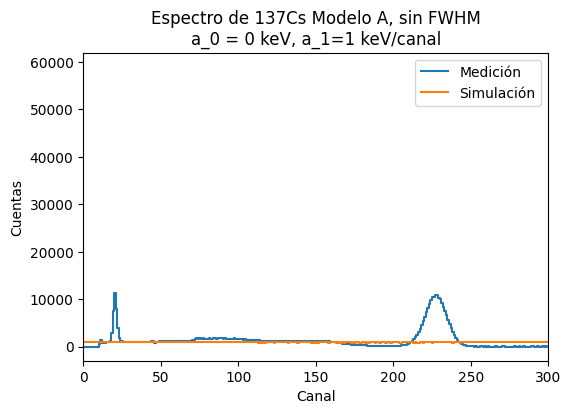

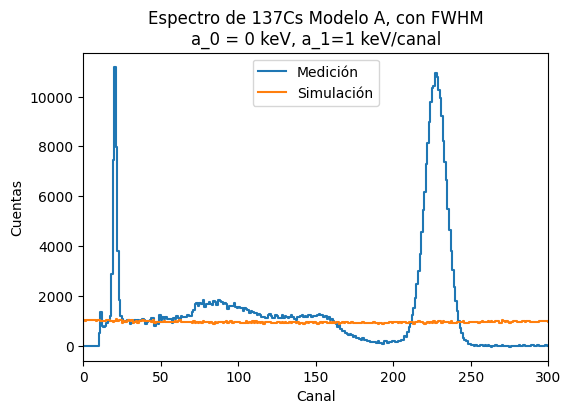

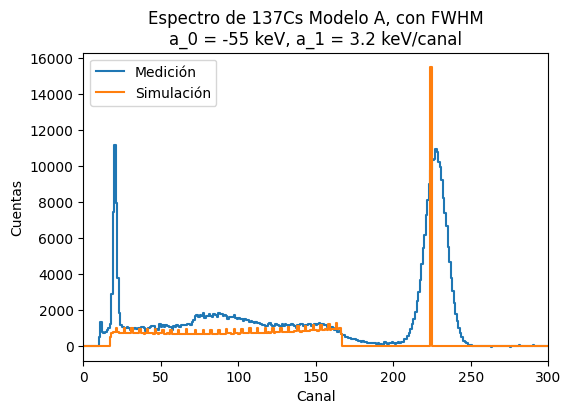

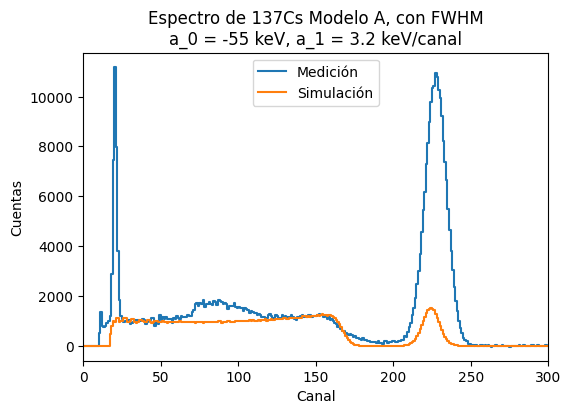

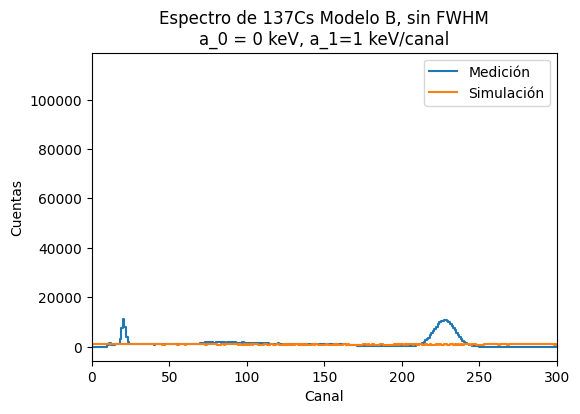

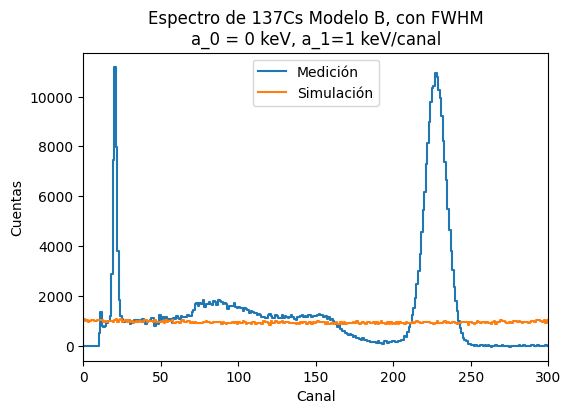

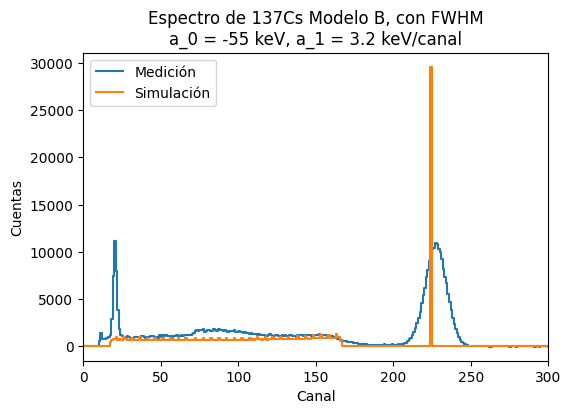

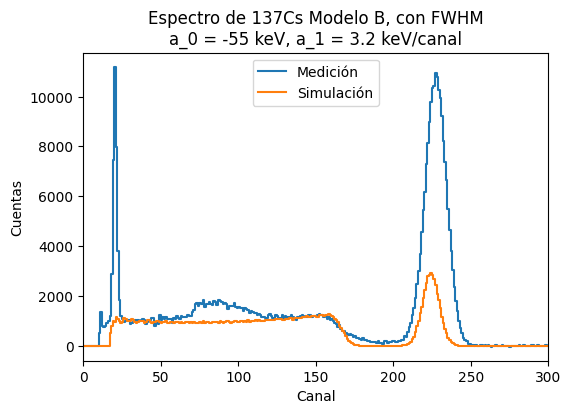

In [6]:
for i in range(len(archivos)):   
    plt.figure(figsize=(6,4))
    plt.step(medicion['canales'], medicion['cuentas'], label='Medición')
    plt.step(simulacion[archivos[i]]['canales'], simulacion[archivos[i]]['cuentas norm'], label='Simulación')
    plt.xlabel('Canal')
    plt.ylabel('Cuentas')
    plt.title(f'Espectro de 137Cs {titulos[i]}')
    plt.legend()
    plt.xlim(0, 300)
    plt.show()

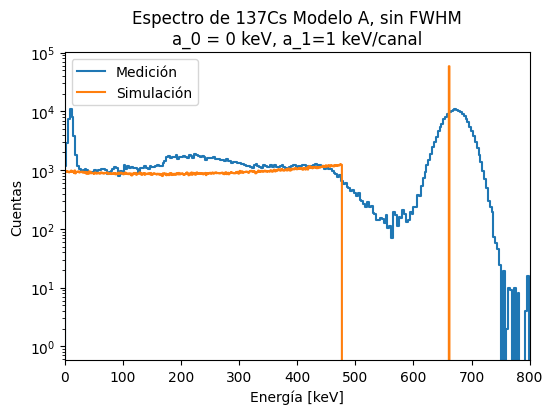

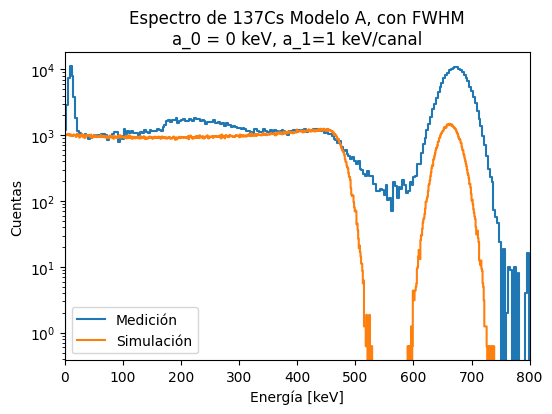

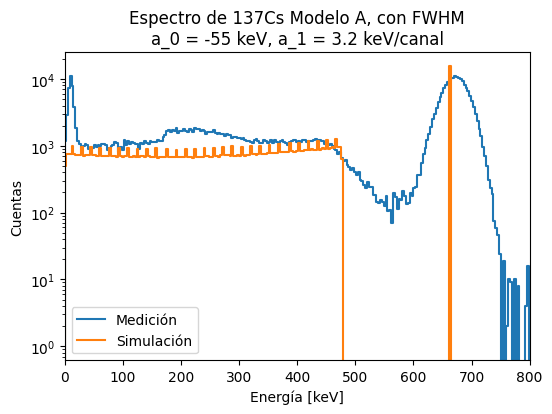

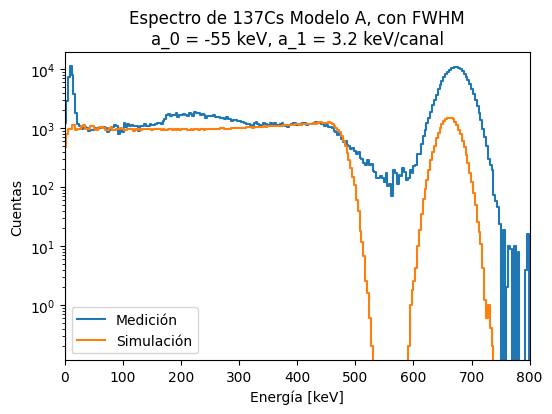

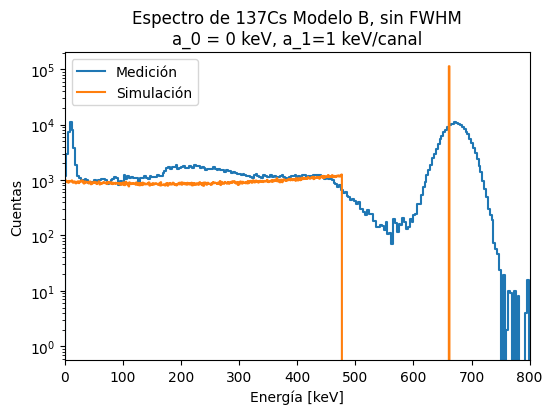

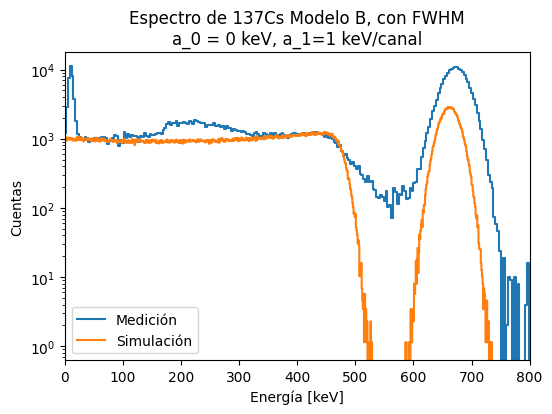

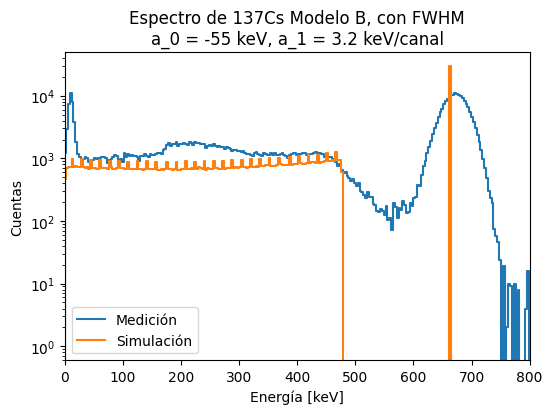

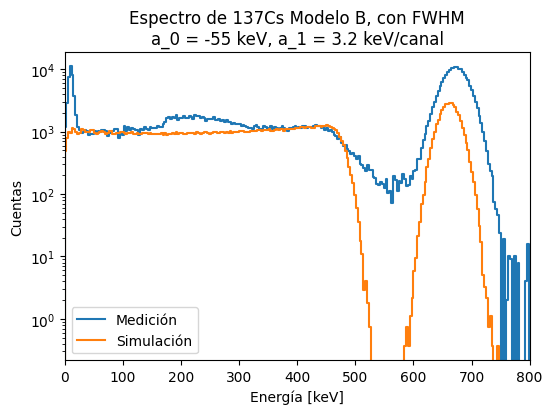

In [5]:
for i in range(len(archivos)):   
    plt.figure(figsize=(6,4))
    plt.step(medicion['energias'], medicion['cuentas'], label='Medición')
    plt.step(simulacion[archivos[i]]['energias'], simulacion[archivos[i]]['cuentas norm'], label='Simulación')
    plt.xlabel('Energía [keV]')
    plt.ylabel('Cuentas')
    plt.title(f'Espectro de 137Cs {titulos[i]}')
    plt.legend()
    plt.xlim(0, 800)
    plt.yscale('log')
    plt.show()